<a href="https://colab.research.google.com/github/saichandra42/SuperMarioReinforcementLearning/blob/main/Mario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mario Environment

In [ ]:
import gym 
import gym_super_mario_bros
import numpy as np
import cv2
import random

import collections
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [ ]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install gym_super_mario_bros

Note: you may need to restart the kernel to use updated packages.


In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3')

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
env = make_env(env)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import collections 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as torchDataUtils
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import gym 
# from environment import env

from tqdm import tqdm
warnings.filterwarnings("ignore")

In [ ]:
# done = True
# for step in range(5):
#     if done:
#         state = env.reset()
#     state, reward, done, info = env.step(env.action_space.sample())
#     # env.render()

# env.close()

In [ ]:
print(env.observation_space.shape)  # Dimensions of a frame
print(env.action_space.n)  # Number of actions our agent can take

(4, 84, 84)
7


In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    """
        Each action of the agent is repeated over skip frames
        return only every `skip`-th frame
    """
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

In [ ]:
class MarioRescale84x84(gym.ObservationWrapper):
    """
    Downsamples/Rescales each frame to size 84x84 with greyscale
    """
    def __init__(self, env=None):
        super(MarioRescale84x84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return MarioRescale84x84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution." 
        # image normalization on RBG
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

In [ ]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Each frame is converted to PyTorch tensors
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

In [ ]:
class BufferWrapper(gym.ObservationWrapper):
    """
    Only every k-th frame is collected by the buffer
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

In [ ]:
class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize pixel values in frame --> 0 to 1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

In [ ]:
def make_env(env):
    env = MaxAndSkipEnv(env)
    env = MarioRescale84x84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = PixelNormalization(env)
    return env

In [ ]:
make_env(env)

<PixelNormalization<BufferWrapper<ImageToPyTorch<MarioRescale84x84<MaxAndSkipEnv<JoypadSpace<ScaledFloatFrame<BufferWrapper<ImageToPyTorch<ProcessFrame84<MaxAndSkipEnv<TimeLimit<OrderEnforcing<SuperMarioBrosEnv<SuperMarioBros-1-1-v3>>>>>>>>>>>>>>>

In [ ]:
class DQNAgent:
    def __init__(self, state_space, action_space, epsilon):
        # Define DQN Layers
        self.state_space = state_space
        self.epsilon = epsilon
        self.action_space = action_space
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'        
        self.dqn = DeepQNetwork(state_space, action_space).to(self.device)
        
    def act(self, state):
        cutoff = np.random.uniform(0,1)
        if cutoff < self.epsilon:
            # Taking a random action
            space_range = random.randrange(self.action_space)
            action = torch.tensor([space_range])
        else:
            # Exploit the environment
            # Forward propogation of the neural network
            max_q_value_getter = self.dqn(state.to(self.device))
            action = torch.argmax(max_q_value_getter).unsqueeze(0).unsqueeze(0).to(self.device)
        return action

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DeepQNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [ ]:
observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = DQNAgent(state_space=observation_space,action_space=action_space,epsilon=0.4)

In [ ]:
def run(env,num_episodes=1000):   
    # Restart the enviroment for each episode
    num_episodes = num_episodes
    env.reset()
    
    total_rewards = []

    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            action = agent.act(state)
            steps += 1
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)                
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)
        
        if ep_num != 0 and ep_num % 5 == 0:
            print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
        num_episodes += 1  
    
    plt.plot(total_rewards)
    plt.show()
    print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))  
    env.close()

  6%|▌         | 6/100 [00:19<03:05,  1.97s/it]

Episode 6 score = 618.0, average score = 336.3333333333333


 11%|█         | 11/100 [00:59<11:17,  7.61s/it]

Episode 11 score = 253.0, average score = 361.72727272727275


 16%|█▌        | 16/100 [01:01<02:15,  1.61s/it]

Episode 16 score = 248.0, average score = 326.75


 21%|██        | 21/100 [02:55<20:34, 15.63s/it]

Episode 21 score = 251.0, average score = 311.76190476190476


 26%|██▌       | 26/100 [04:52<30:35, 24.80s/it]

Episode 26 score = 267.0, average score = 302.34615384615387


 31%|███       | 31/100 [06:24<27:09, 23.62s/it]

Episode 31 score = 268.0, average score = 305.16129032258067


 36%|███▌      | 36/100 [06:55<06:53,  6.47s/it]

Episode 36 score = 251.0, average score = 297.3888888888889


 41%|████      | 41/100 [08:12<11:30, 11.71s/it]

Episode 41 score = 252.0, average score = 295.8292682926829


 46%|████▌     | 46/100 [08:56<05:31,  6.13s/it]

Episode 46 score = 248.0, average score = 304.67391304347825


 51%|█████     | 51/100 [09:11<02:53,  3.53s/it]

Episode 51 score = 249.0, average score = 311.4901960784314


 56%|█████▌    | 56/100 [09:30<01:59,  2.72s/it]

Episode 56 score = 251.0, average score = 308.60714285714283


 61%|██████    | 61/100 [10:42<09:25, 14.51s/it]

Episode 61 score = 267.0, average score = 307.7704918032787


 66%|██████▌   | 66/100 [11:04<02:34,  4.55s/it]

Episode 66 score = 251.0, average score = 311.1363636363636


 71%|███████   | 71/100 [11:41<05:10, 10.71s/it]

Episode 71 score = 267.0, average score = 311.38028169014086


 76%|███████▌  | 76/100 [12:45<03:33,  8.88s/it]

Episode 76 score = 253.0, average score = 312.57894736842104


 81%|████████  | 81/100 [13:57<04:38, 14.68s/it]

Episode 81 score = 267.0, average score = 317.38271604938274


 86%|████████▌ | 86/100 [15:29<03:35, 15.37s/it]

Episode 86 score = 243.0, average score = 317.1860465116279


 91%|█████████ | 91/100 [16:33<02:11, 14.62s/it]

Episode 91 score = 267.0, average score = 317.5054945054945


 96%|█████████▌| 96/100 [17:42<00:39,  9.99s/it]

Episode 96 score = 577.0, average score = 324.1354166666667


100%|██████████| 100/100 [18:17<00:00, 10.98s/it]


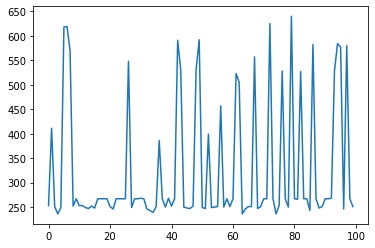

Episode 100 score = 251.0, average score = 324.61


In [ ]:
run(env,num_episodes=100)